In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.table import Table
import pandas as pd
import time
import pyccl as ccl
pd.options.display.max_columns = 500

import sys
#sys.path.append('/Users/Georg022/Documents/Python_scripts/my_python_libs')

ModuleNotFoundError: No module named 'pyccl'

In [2]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['text.usetex'] = 'True'

In [3]:
data = Table.read('./lowz12_v5_short.fits', format='fits').to_pandas()

In [4]:
data = data[data['Z']>0]

# Singh+2015 - WMAP9 Cosmology
cosmo = ccl.Cosmology(Omega_c = 0.236, Omega_b = 0.046, h = 0.7, sigma8 = 0.817, n_s = 0.9646)

data['DA'] = ccl.angular_diameter_distance(cosmo,1/(1+data['Z']))*cosmo['h'] # in Mpc/h

In [5]:
data.head()

,RA,DEC,Z,e1,e2,WEIGHT_FKP,WEIGHT_CP,WEIGHT_NOZ,WEIGHT_STAR,WEIGHT_SEEING,WEIGHT_SYSTOT,Mu_ke0,Mg_ke0,Mr_ke0,Mi_ke0,Mz_ke0,DA
0,195.211710,-0.505258,0.345888,0.158104,-0.076799,0.227029,1.0,1.0,1.0,1.0,1.0,-999.000000,-20.884115,-21.622444,-22.054237,-22.444876,710.940051
1,225.586971,-0.046532,0.332610,0.107626,0.033516,0.226787,1.0,1.0,1.0,1.0,1.0,-19.535934,-20.940083,-21.751516,-22.148893,-22.532366,692.738176
2,225.513692,-0.190260,0.332531,-0.055152,-0.128687,0.227034,1.0,1.0,1.0,1.0,1.0,-999.000000,-20.736992,-21.573034,-21.956991,-22.253622,692.627276
3,195.151124,0.357886,0.384936,0.099997,-0.247254,0.304371,1.0,1.0,1.0,1.0,1.0,-999.000000,-21.006050,-21.805061,-22.199631,-22.518621,761.429606
4,195.095915,-1.063041,0.248512,-0.085485,0.213857,0.236770,1.0,1.0,1.0,1.0,1.0,-18.734627,-21.157776,-21.927965,-22.281872,-22.573008,563.920793


In [6]:
data['Z'].mean()

0.28820986

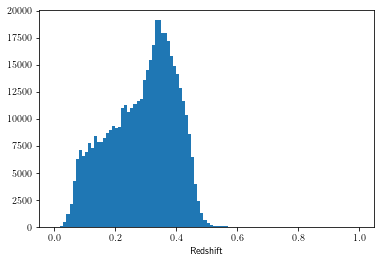

In [7]:
plt.hist(data['Z'], bins=100)
plt.xlabel('Redshift')
plt.show()

In [8]:
z_mask = (data['Z']>0.16) &(data['Z']<0.36)
e_mask = (data['e1']>-900) & (data['e2']>-900)  & ((data['e1']**2+data['e2']**2)**0.5<2)
mr_mask = (data['Mr_ke0']>-900) & (data['Mr_ke0']<-15)
mu_mask = (data['Mu_ke0']>-900) & (data['Mu_ke0']<-15)
mz_mask = (data['Mz_ke0']>-900) & (data['Mz_ke0']<-15)

density = data[z_mask] #& e_mask]# & mr_mask & mu_mask & mz_mask]
print('Density sample:',density.shape[0])

shapes = data[z_mask & e_mask]# & mr_mask & mu_mask & mz_mask]
print('Shapes sample:',shapes.shape[0])

Density sample: 249938
Shapes sample: 192197


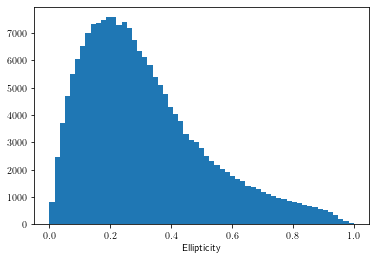

In [9]:
plt.hist((shapes['e1']**2+shapes['e2']**2)**0.5, bins=59)
plt.xlabel('Ellipticity')
plt.show()

In [10]:
shapes['Z'].mean()

0.2745195

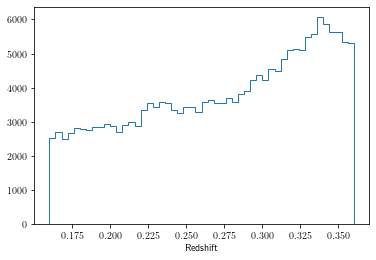

In [11]:
plt.hist(shapes['Z'], bins=50, histtype='step')
plt.xlabel('Redshift')
plt.show()

Showing edges for the 20% quantiles:
[-24.         -22.17016894 -21.94525637 -21.77475133 -21.59251221
 -20.        ]


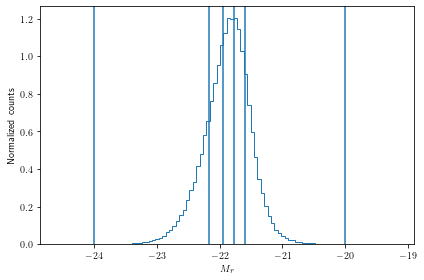

In [49]:
from scipy.stats import rv_histogram
Mr_hist, bin_edges = np.histogram(shapes['Mr_ke0'], bins=np.linspace(-24, -20, 100))
hist_dist = rv_histogram((Mr_hist, bin_edges))

N_bins = 5
quantiles = np.linspace(0, 1, N_bins+1)
Mr_bin_edges = hist_dist.ppf(quantiles)
print('Showing edges for the %.0f%% quantiles:'%(100/N_bins))
print(Mr_bin_edges)

fig, ax = plt.subplots(1,1)
ax.hist(shapes['Mr_ke0'], bins=100, histtype='step', density=True)
for mr in Mr_bin_edges:
    ax.axvline(x=mr)
ax.set_xlabel('$M_r$')
ax.set_ylabel('Normalized counts')
fig.tight_layout()
plt.show()

Text(0, 0.5, '$\\langle M_r \\rangle$')

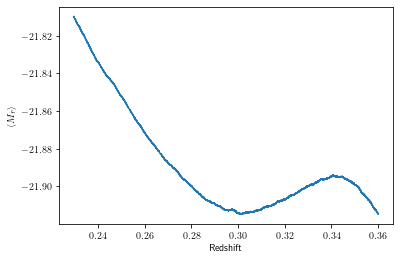

In [13]:
srt_shapes = shapes.sort_values(by='Z')

srt_shapes['mean_Mr'] = srt_shapes['Mr_ke0'].rolling(50000).mean()

plt.plot(srt_shapes.dropna()['Z'], srt_shapes.dropna()['mean_Mr'])
plt.xlabel('Redshift')
plt.ylabel(r'$\langle M_r \rangle$')

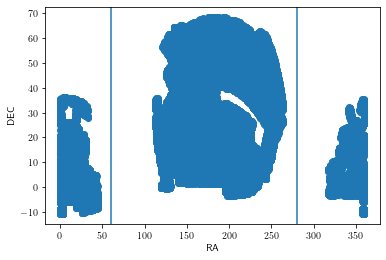

In [14]:
plt.scatter(shapes['RA'], shapes['DEC'])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.axvline(x=280)
plt.axvline(x=60)
plt.show()

In [30]:
north_shapes = shapes[(shapes['RA']>60) & (shapes['RA']<280)]
south_shapes = shapes[(shapes['RA']<60) | (shapes['RA']>280)]

north_density = density[(density['RA']>60) & (density['RA']<280)]
south_density = density[(density['RA']<60) | (density['RA']>280)]

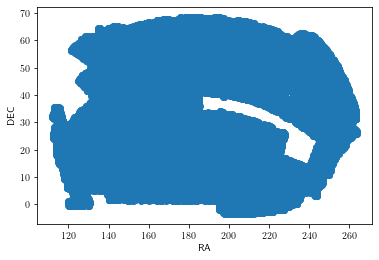

In [37]:
plt.scatter(north_shapes['RA'], north_shapes['DEC'])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

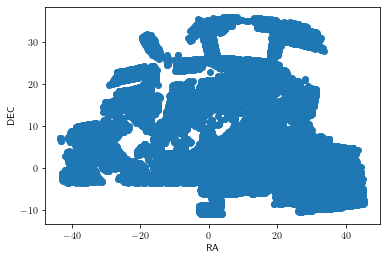

In [38]:
plt.scatter(south_shapes['RA'][south_shapes['RA']<100], south_shapes['DEC'][south_shapes['RA']<100], c='C0')
plt.scatter(south_shapes['RA'][south_shapes['RA']>100]-360, south_shapes['DEC'][south_shapes['RA']>100], c='C0')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [50]:
RA_cen, DEC_cen = north_shapes['RA'].mean(), north_shapes['DEC'].mean()
print(RA_cen, DEC_cen)

north_shapes['X'] = np.deg2rad(north_shapes['RA']-RA_cen)*north_shapes['DA']/np.cos(np.deg2rad(north_shapes['DEC']))
north_shapes['Y'] = np.deg2rad(north_shapes['DEC']-DEC_cen)*north_shapes['DA']

north_density['X'] = np.deg2rad(north_density['RA']-RA_cen)*north_density['DA']/np.cos(np.deg2rad(north_density['DEC']))
north_density['Y'] = np.deg2rad(north_density['DEC']-DEC_cen)*north_density['DA']

185.55395776068553 28.61957232430468


/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/291557440.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_shapes['X'] = np.deg2rad(north_shapes['RA']-RA_cen)*north_shapes['DA']/np.cos(np.deg2rad(north_shapes['DEC']))
/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/291557440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_shapes['Y'] = np.deg2rad(north_shapes['DEC']-DEC_cen)*north_shapes['DA']
/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/

In [52]:
RA_cen, DEC_cen = 0., south_shapes['DEC'].mean()
print(RA_cen, DEC_cen)

south_shapes['X'] = np.deg2rad(south_shapes['RA']-RA_cen)*south_shapes['DA']/np.cos(np.deg2rad(south_shapes['DEC']))
south_shapes['Y'] = np.deg2rad(south_shapes['DEC']-DEC_cen)*south_shapes['DA']

south_density['X'] = np.deg2rad(south_density['RA']-RA_cen)*south_density['DA']/np.cos(np.deg2rad(south_density['DEC']))
south_density['Y'] = np.deg2rad(south_density['DEC']-DEC_cen)*south_density['DA']

0.0 7.336028459665522


/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/604885217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_shapes['X'] = np.deg2rad(south_shapes['RA']-RA_cen)*south_shapes['DA']/np.cos(np.deg2rad(south_shapes['DEC']))
/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/604885217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_shapes['Y'] = np.deg2rad(south_shapes['DEC']-DEC_cen)*south_shapes['DA']
/var/folders/mq/yzz79x0924l5y9zgs04n8kkr0000gp/T/ipykernel_3193/

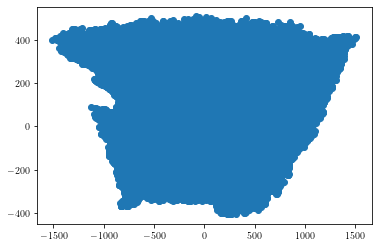

In [54]:
plt.scatter(north_shapes['X'], north_shapes['Y'])

# Random catalogues

In [21]:
randoms_south = Table.read('./random0_DR12v5_LOWZ_South.fits', 1)

In [22]:
randoms_south[:5]

RA,DEC,Z,WEIGHT_FKP,NZ,IPOLY,ISECT,SKYFLUX [5],IMAGE_DEPTH [5],AIRMASS,EB_MINUS_V,PSF_FWHM [5],ZINDX
float64,float64,float64,float64,float64,int16,int16,float32,float32,float32,float32,float32,int32
341.64382,22.744648,0.3581112027168274,0.23811082541942596,0.0003199725179001689,15622,9734,2.7950757 .. 30.28177,1.2656713 .. 4.0145526,1.0178019,0.060833305,1.2353776 .. 1.0369885,66726
339.98639,13.279577,0.3433419466018677,0.2164953649044037,0.00036190368700772524,21871,5760,0.8587745 .. 15.871193,0.7729946 .. 3.0144892,1.063828,0.043874122,1.3340514 .. 1.0729594,19671
358.325043,22.101216,0.3340875208377838,0.20524509251117706,0.000387222389690578,15711,9597,2.5150497 .. 39.354202,1.4204803 .. 5.264819,1.0675305,0.115435556,1.4315891 .. 1.1900231,41578
11.080719,22.798487,0.10490182787179947,0.08182866871356964,0.0011220655869692564,14473,10522,2.1842456 .. 34.199505,1.8145217 .. 4.9478784,1.560856,0.032909337,1.5567251 .. 1.1655307,123882
359.466067,16.501436,0.24671000242233276,0.2174908071756363,0.00035978955565951765,19531,9901,1.363769 .. 31.00633,1.359794 .. 4.995681,1.286331,0.03432553,1.676938 .. 1.2556009,120063


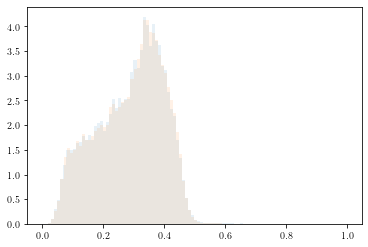

In [23]:
plt.hist(randoms_south['Z'], bins=100, density=True, alpha=0.1)
plt.hist(data['Z'], bins=100, density=True, alpha=0.1)
plt.show()

In [24]:
randoms_south[['RA', 'DEC', 'Z']][:5]

RA,DEC,Z
float64,float64,float64
341.64382,22.744648,0.3581112027168274
339.98639,13.279577,0.3433419466018677
358.325043,22.101216,0.3340875208377838
11.080719,22.798487,0.10490182787179947
359.466067,16.501436,0.24671000242233276
